<a href="https://colab.research.google.com/github/noambassat/SupremeCourtClassifier/blob/main/6_Both_models_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype
import ast
import joblib

In [2]:
raap = pd.read_csv("RAAP.csv")

In [3]:
for col in raap.columns:
  print(col)

מספר תיק
מספר החלטות בתיק
שם הליך
שנת פתיחת ההליך
מספר הליך
סוג הליך
פירוט סוג הליך
תיק חסוי
תאריך אירוע אחרון
משך התיק בימים
תאריך הגשה
מתוקן סוג הליך
תאריך יצוא התיק
תאריך יצוא הקובץ
תאריך נרמול הקובץ
שם הקובץ
קישור לתיק
שם גורם שיפוטי
תואר גורם שיפוטי
מספר גורמים שיפוטיים במותב
ID
שם השופט
שם השופט מנורמל
שם משפחה מנורמל
שם פרטי מנורמל
מגדר
לאום
דת
קבוצה דתית
שיוך עדתי
ארץ/איזור לידה
שנת לידה
יישוב מגורים מרכזי בילדות
דירוג חברתי כלכלי של  יישוב מגורים מרכזי בילדות
בית ספר תיכון
סוג החינוך
מוסד חינוך משפטי עיקרי
שנת סיום התואר הראשון במשפטים
סוג השכלה משפטית מתקדמת
מוסד חינוך משפטי מתקדם
שנת קבלת התואר המתקדם
מקום התמחות
שנת הסמכה כעורך/ת דין
המשרה האחרונה טרם המינוי לשיפוט
משרה שיפוטית 1
שם בית המשפט במשרה שיפוטית 1
שנת מינוי למשרה שיפוטית 1
משרה שיפוטית 2
שם בית המשפט במשרה שיפוטית 2
שנת מינוי למשרה שיפוטית 2
משרה שיפוטית 3
שם בית המשפט במשרה שיפוטית 3
שנת מינוי למשרה שיפוטית 3
משרה שיפוטית 4
שם בית המשפט במשרה שיפוטית 4
שנת מינוי למשפרה שיפוטית 4
משרה שיפוטית 5
שם בית המשפט במשרה

In [4]:
raap["ניתנה החלטה כמבוקש הבקשה"].unique()

array([nan, "['אין מידע']", "['אין מידע', 'אין מידע', 'אין מידע']",
       "['אין מידע', 'אין מידע']",
       "['אין מידע', 'אין מידע', 'אין מידע', 'אין מידע']",
       "['אין מידע', 'אין מידע', 'אין מידע', 'אין מידע', 'אין מידע']",
       "['אין מידע', 'אין מידע', 'אין מידע', 'אין מידע', 'אין מידע', 'אין מידע']",
       "['אין מידע', 'אין מידע', 'אין מידע', 'אין מידע', 'אין מידע', 'אין מידע', 'אין מידע', 'אין מידע']",
       "['אין מידע', 'אין מידע', 'אין מידע', 'אין מידע', 'אין מידע', 'אין מידע', 'אין מידע']",
       "['אין מידע', 'אין מידע', 'אין מידע', 'אין מידע', 'אין מידע', 'אין מידע', 'אין מידע', 'אין מידע', 'אין מידע', 'אין מידע', 'אין מידע', 'אין מידע', 'אין מידע', 'אין מידע', 'אין מידע']",
       "['אין מידע', 'אין מידע', '28/10/2012', 'אין מידע', 'אין מידע', 'אין מידע', 'אין מידע', 'אין מידע']",
       "['אין מידע', 'אין מידע', 'אין מידע', '08/08/2013', 'אין מידע']",
       "['אין מידע', 'אין מידע', 'אין מידע', 'אין מידע', '03/09/2018']",
       "['אין מידע', 'אין מידע', '10

נקודה חשובה לציון - בשנים 2000-2001 יש הבדל מהותי בין שם ההליך ומתוכו סוג ההליך, לבין סוג ההליך שנרשם בגוף המסמך עצמו.

# Clean Doc's body - נקיון גוף המסמך

In [5]:
# פונקציה להמרת טקסט שמופיע כרשימה למחרוזת רגילה
def convert_list_to_string(text):
    if isinstance(text, str) and text.startswith("[") and text.endswith("]"):
        try:
            # מנסה להמיר את התוכן בתוך הסוגריים לרשימה אמיתית
            text_list = ast.literal_eval(text)
            # איחוד המחרוזות לרצף טקסט אחד
            return ' '.join(text_list)
        except (ValueError, SyntaxError):
            return text
    return text

# פונקציה לניקוי התווים המיותרים
def clean_text(text):
    if isinstance(text, list):
        text = ' '.join(text)  # הפיכת רשימה למחרוזת
    elif isinstance(text, str):
        # הסרת תווי רווח מיותרים ותווים מיוחדים
        text = re.sub(r'\n+', ' ', text)  # הסרת שורות חדשות מרובות
        text = re.sub(r'\\n', '', text)   # הסרת תווי newline \n מהטקסט
        text = re.sub(r'\\xa0', ' ', text)  # הסרת תווי \xa0 מהטקסט
        text = re.sub(r'\s+', ' ', text)  # הסרת רווחים מרובים
        return text.strip()
    return text

# הדפסת שורות לא קריאות לפני המרה
print("שורות לא קריאות לפני המרה:")
print(raap["גוף המסמך"].head())

# המרה של הטקסטים הלא קריאים לטקסטים קריאים ושמירה על הדאטה המקורי
raap["גוף המסמך"] = raap["גוף המסמך"].apply(clean_text)

print("\nשורות לאחר המרה:")
print(raap["גוף המסמך"].head())

# file_path = 'full_final_df_cleaned.csv'
# df_full_ra_rap.to_csv(file_path, index=False, encoding='utf-8')

# print(f"הקובץ נשמר בהצלחה בנתיב: {file_path}")


שורות לא קריאות לפני המרה:
0    ['החלטה בתיק רע"פ 5144/18 בבית המשפט העליון רע...
1    ['החלטה בתיק רע"פ 1746/18 בבית המשפט העליון רע...
2    ['החלטה בתיק רע"פ 4262/18 בבית המשפט העליון רע...
3    ['החלטה בתיק רע"פ 1654/18 בבית המשפט העליון רע...
4    ['החלטה בתיק רע"פ 5548/18 בבית המשפט העליון רע...
Name: גוף המסמך, dtype: object

שורות לאחר המרה:
0    ['החלטה בתיק רע"פ 5144/18 בבית המשפט העליון רע...
1    ['החלטה בתיק רע"פ 1746/18 בבית המשפט העליון רע...
2    ['החלטה בתיק רע"פ 4262/18 בבית המשפט העליון רע...
3    ['החלטה בתיק רע"פ 1654/18 בבית המשפט העליון רע...
4    ['החלטה בתיק רע"פ 5548/18 בבית המשפט העליון רע...
Name: גוף המסמך, dtype: object


# DCA Files only

In [6]:
years = list(range(2008, 2013, 1))
years

[2008, 2009, 2010, 2011, 2012]

In [7]:
sample_df = raap[raap["שנת פתיחת ההליך"].isin(years)]
sample_df

,מספר תיק,מספר החלטות בתיק,שם הליך,שנת פתיחת ההליך,מספר הליך,סוג הליך,פירוט סוג הליך,תיק חסוי,תאריך אירוע אחרון,משך התיק בימים,...,סוג גורם שיפוטי דלמטה,סוג בית משפט דלמטה,מקום בית משפט דלמטה,הליך מאוחד,שמות ההליכים המאוחדים,צדדים נוספים,מספר תיק מלא,מספר השופטים,ניתנה החלטה כמבוקש הבקשה,Year
2202,4600/12,1,"רע""פ 4600/12",2012,"רע""פ 4600/12","רע""פ",רשות ערעור פלילי,0.0,2012-06-14,1,...,"['שופט', 'שופט']","['מחוזי ', 'שלום']","['חיפה', 'חדרה']",NaN,NaN,NaN,NaN,NaN,['אין מידע'],2012
2203,1994/12,3,"רע""פ 1994/12 ראובנ הירש נ. מדינת ישראל",2012,"רע""פ 1994/12","רע""פ",רשות ערעור פלילי,0.0,2013-06-03,61,...,['שופט'],['מחוזי '],['חיפה'],NaN,NaN,NaN,NaN,NaN,"['אין מידע', 'אין מידע', 'אין מידע', 'אין מידע...",2012
2204,7822/12,2,"רע""פ 7822/12",2012,"רע""פ 7822/12","רע""פ",רשות ערעור פלילי,1.0,1900-01-01,-2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012
2205,9273/12,1,"רע""פ 9273/12 מלי לגו נ. מדינת ישראל",2012,"רע""פ 9273/12","רע""פ",רשות ערעור פלילי,0.0,2013-01-01,3,...,"['שופט', 'שופט']","['תעבורה', 'מחוזי ']","['תל אביב-יפו', 'תל אביב']",NaN,NaN,NaN,NaN,NaN,NaN,2012
2206,2901/12,6,"רע""פ 2901/12 ירונ אושרי נ. מדינת ישראל",2012,"רע""פ 2901/12","רע""פ",רשות ערעור פלילי,0.0,2013-05-16,113,...,"['שופט', 'שופט']","['תעבורה', 'מחוזי ']","['תל אביב-יפו', 'תל אביב']",NaN,NaN,NaN,NaN,NaN,['אין מידע'],2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6738,8581/11,2,"רע""פ 8581/11 יוספ ניסימ סטיונ נ. מדינת ישראל",2011,"רע""פ 8581/11","רע""פ",רשות ערעור פלילי,0.0,2011-12-06,9,...,"['שופט', 'שופט']","['מחוזי ', 'שלום']","['תל אביב', 'תל אביב']",NaN,NaN,NaN,NaN,NaN,NaN,2011
6739,1728/11,1,"רע""פ 1728/11 מאיר לוי נ. מדינת ישראל",2011,"רע""פ 1728/11","רע""פ",רשות ערעור פלילי,0.0,2011-03-09,5,...,['שופט'],['מחוזי '],['תל אביב'],NaN,NaN,NaN,NaN,NaN,NaN,2011
6740,3371/11,3,"רע""פ 3371/11 אור וקנינ נ. התובע הצבאי הראשי",2011,"רע""פ 3371/11","רע""פ",רשות ערעור פלילי,0.0,2011-05-18,9,...,"['שופט', 'שופט']","['בית הדין הצבאי לערעורים', 'בית הדין הצבאי לע...",NaN,NaN,NaN,NaN,NaN,NaN,"['אין מידע', 'אין מידע']",2011
6741,3352/11,1,"רע""פ 3352/11 אריה כדורי נ. מדינת ישראל",2011,"רע""פ 3352/11","רע""פ",רשות ערעור פלילי,0.0,2011-05-15,10,...,"['שופט', 'שופט']","['תעבורה', 'מחוזי ']","['פתח תקווה', 'מרכז-לוד']",NaN,NaN,NaN,NaN,NaN,NaN,2011


In [8]:
sample_df["שנת פתיחת ההליך"].unique()

array([2012, 2008, 2009, 2010, 2011])

In [9]:
sample_df = sample_df[sample_df["סוג הליך"]=='רע"פ']
# בדיקה אם בעמודת "גוף המסמך" קיימת המילה "רע"פ"
contains_raap = sample_df["גוף המסמך"].str.contains('רע"פ', na=False)

# ספירה של כמה מסמכים מכילים את המילה רע"פ וכמה לא
count_yes = contains_raap.sum()
count_no = len(contains_raap) - count_yes

# הדפסת הספירה
print(f"מספר המסמכים שמכילים את המילה 'רע\"פ': {count_yes}")
print(f"מספר המסמכים שלא מכילים את המילה 'רע\"פ': {count_no}")

# סינון הדאטה לשמירת רק המסמכים שכן מכילות את המילה
sample_df = sample_df[contains_raap]

מספר המסמכים שמכילים את המילה 'רע"פ': 2327
מספר המסמכים שלא מכילים את המילה 'רע"פ': 0


In [10]:
sample_df = sample_df[
    (sample_df["סוג הליך"] == 'רע"פ') &
    (sample_df["מספר הליך"].str.contains('רע"פ', na=False))
]
sample_df

,מספר תיק,מספר החלטות בתיק,שם הליך,שנת פתיחת ההליך,מספר הליך,סוג הליך,פירוט סוג הליך,תיק חסוי,תאריך אירוע אחרון,משך התיק בימים,...,סוג גורם שיפוטי דלמטה,סוג בית משפט דלמטה,מקום בית משפט דלמטה,הליך מאוחד,שמות ההליכים המאוחדים,צדדים נוספים,מספר תיק מלא,מספר השופטים,ניתנה החלטה כמבוקש הבקשה,Year
2202,4600/12,1,"רע""פ 4600/12",2012,"רע""פ 4600/12","רע""פ",רשות ערעור פלילי,0.0,2012-06-14,1,...,"['שופט', 'שופט']","['מחוזי ', 'שלום']","['חיפה', 'חדרה']",NaN,NaN,NaN,NaN,NaN,['אין מידע'],2012
2203,1994/12,3,"רע""פ 1994/12 ראובנ הירש נ. מדינת ישראל",2012,"רע""פ 1994/12","רע""פ",רשות ערעור פלילי,0.0,2013-06-03,61,...,['שופט'],['מחוזי '],['חיפה'],NaN,NaN,NaN,NaN,NaN,"['אין מידע', 'אין מידע', 'אין מידע', 'אין מידע...",2012
2204,7822/12,2,"רע""פ 7822/12",2012,"רע""פ 7822/12","רע""פ",רשות ערעור פלילי,1.0,1900-01-01,-2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012
2205,9273/12,1,"רע""פ 9273/12 מלי לגו נ. מדינת ישראל",2012,"רע""פ 9273/12","רע""פ",רשות ערעור פלילי,0.0,2013-01-01,3,...,"['שופט', 'שופט']","['תעבורה', 'מחוזי ']","['תל אביב-יפו', 'תל אביב']",NaN,NaN,NaN,NaN,NaN,NaN,2012
2206,2901/12,6,"רע""פ 2901/12 ירונ אושרי נ. מדינת ישראל",2012,"רע""פ 2901/12","רע""פ",רשות ערעור פלילי,0.0,2013-05-16,113,...,"['שופט', 'שופט']","['תעבורה', 'מחוזי ']","['תל אביב-יפו', 'תל אביב']",NaN,NaN,NaN,NaN,NaN,['אין מידע'],2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6738,8581/11,2,"רע""פ 8581/11 יוספ ניסימ סטיונ נ. מדינת ישראל",2011,"רע""פ 8581/11","רע""פ",רשות ערעור פלילי,0.0,2011-12-06,9,...,"['שופט', 'שופט']","['מחוזי ', 'שלום']","['תל אביב', 'תל אביב']",NaN,NaN,NaN,NaN,NaN,NaN,2011
6739,1728/11,1,"רע""פ 1728/11 מאיר לוי נ. מדינת ישראל",2011,"רע""פ 1728/11","רע""פ",רשות ערעור פלילי,0.0,2011-03-09,5,...,['שופט'],['מחוזי '],['תל אביב'],NaN,NaN,NaN,NaN,NaN,NaN,2011
6740,3371/11,3,"רע""פ 3371/11 אור וקנינ נ. התובע הצבאי הראשי",2011,"רע""פ 3371/11","רע""פ",רשות ערעור פלילי,0.0,2011-05-18,9,...,"['שופט', 'שופט']","['בית הדין הצבאי לערעורים', 'בית הדין הצבאי לע...",NaN,NaN,NaN,NaN,NaN,NaN,"['אין מידע', 'אין מידע']",2011
6741,3352/11,1,"רע""פ 3352/11 אריה כדורי נ. מדינת ישראל",2011,"רע""פ 3352/11","רע""פ",רשות ערעור פלילי,0.0,2011-05-15,10,...,"['שופט', 'שופט']","['תעבורה', 'מחוזי ']","['פתח תקווה', 'מרכז-לוד']",NaN,NaN,NaN,NaN,NaN,NaN,2011


In [11]:
sample_df.shape[0]

2327

# Drop null

In [12]:
sample_df[["גוף המסמך"]].dropna(how='any', ignore_index=True,inplace=True)
sample_df[["מספר הליך","שם הליך"]].dropna(how='all', ignore_index=True,inplace=True)
sample_df[["מספר הליך","שם הליך"]].drop_duplicates(inplace=True, ignore_index=True)
sample_df

<ipython-input-12-9f43abb7fdde>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df[["גוף המסמך"]].dropna(how='any', ignore_index=True,inplace=True)
<ipython-input-12-9f43abb7fdde>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df[["מספר הליך","שם הליך"]].dropna(how='all', ignore_index=True,inplace=True)
<ipython-input-12-9f43abb7fdde>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df[["מספר הליך","שם הליך"]].d

,מספר תיק,מספר החלטות בתיק,שם הליך,שנת פתיחת ההליך,מספר הליך,סוג הליך,פירוט סוג הליך,תיק חסוי,תאריך אירוע אחרון,משך התיק בימים,...,סוג גורם שיפוטי דלמטה,סוג בית משפט דלמטה,מקום בית משפט דלמטה,הליך מאוחד,שמות ההליכים המאוחדים,צדדים נוספים,מספר תיק מלא,מספר השופטים,ניתנה החלטה כמבוקש הבקשה,Year
2202,4600/12,1,"רע""פ 4600/12",2012,"רע""פ 4600/12","רע""פ",רשות ערעור פלילי,0.0,2012-06-14,1,...,"['שופט', 'שופט']","['מחוזי ', 'שלום']","['חיפה', 'חדרה']",NaN,NaN,NaN,NaN,NaN,['אין מידע'],2012
2203,1994/12,3,"רע""פ 1994/12 ראובנ הירש נ. מדינת ישראל",2012,"רע""פ 1994/12","רע""פ",רשות ערעור פלילי,0.0,2013-06-03,61,...,['שופט'],['מחוזי '],['חיפה'],NaN,NaN,NaN,NaN,NaN,"['אין מידע', 'אין מידע', 'אין מידע', 'אין מידע...",2012
2204,7822/12,2,"רע""פ 7822/12",2012,"רע""פ 7822/12","רע""פ",רשות ערעור פלילי,1.0,1900-01-01,-2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012
2205,9273/12,1,"רע""פ 9273/12 מלי לגו נ. מדינת ישראל",2012,"רע""פ 9273/12","רע""פ",רשות ערעור פלילי,0.0,2013-01-01,3,...,"['שופט', 'שופט']","['תעבורה', 'מחוזי ']","['תל אביב-יפו', 'תל אביב']",NaN,NaN,NaN,NaN,NaN,NaN,2012
2206,2901/12,6,"רע""פ 2901/12 ירונ אושרי נ. מדינת ישראל",2012,"רע""פ 2901/12","רע""פ",רשות ערעור פלילי,0.0,2013-05-16,113,...,"['שופט', 'שופט']","['תעבורה', 'מחוזי ']","['תל אביב-יפו', 'תל אביב']",NaN,NaN,NaN,NaN,NaN,['אין מידע'],2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6738,8581/11,2,"רע""פ 8581/11 יוספ ניסימ סטיונ נ. מדינת ישראל",2011,"רע""פ 8581/11","רע""פ",רשות ערעור פלילי,0.0,2011-12-06,9,...,"['שופט', 'שופט']","['מחוזי ', 'שלום']","['תל אביב', 'תל אביב']",NaN,NaN,NaN,NaN,NaN,NaN,2011
6739,1728/11,1,"רע""פ 1728/11 מאיר לוי נ. מדינת ישראל",2011,"רע""פ 1728/11","רע""פ",רשות ערעור פלילי,0.0,2011-03-09,5,...,['שופט'],['מחוזי '],['תל אביב'],NaN,NaN,NaN,NaN,NaN,NaN,2011
6740,3371/11,3,"רע""פ 3371/11 אור וקנינ נ. התובע הצבאי הראשי",2011,"רע""פ 3371/11","רע""פ",רשות ערעור פלילי,0.0,2011-05-18,9,...,"['שופט', 'שופט']","['בית הדין הצבאי לערעורים', 'בית הדין הצבאי לע...",NaN,NaN,NaN,NaN,NaN,NaN,"['אין מידע', 'אין מידע']",2011
6741,3352/11,1,"רע""פ 3352/11 אריה כדורי נ. מדינת ישראל",2011,"רע""פ 3352/11","רע""פ",רשות ערעור פלילי,0.0,2011-05-15,10,...,"['שופט', 'שופט']","['תעבורה', 'מחוזי ']","['פתח תקווה', 'מרכז-לוד']",NaN,NaN,NaN,NaN,NaN,NaN,2011


In [13]:
cut_sample_df = sample_df[["גוף המסמך","מספר הליך","שם הליך","שנת פתיחת ההליך"]].reset_index()
cut_sample_df

,index,גוף המסמך,מספר הליך,שם הליך,שנת פתיחת ההליך
0,2202,"['החלטה בתיק רע""פ 4600/12 בבית המשפט העליון רע...","רע""פ 4600/12","רע""פ 4600/12",2012
1,2203,"['החלטה בתיק רע""פ 1994/12 בבית המשפט העליון בי...","רע""פ 1994/12","רע""פ 1994/12 ראובנ הירש נ. מדינת ישראל",2012
2,2204,"['החלטה בתיק רע""פ 7822/12 בבית המשפט העליון רע...","רע""פ 7822/12","רע""פ 7822/12",2012
3,2205,"['החלטה בתיק רע""פ 9273/12 בבית המשפט העליון רע...","רע""פ 9273/12","רע""פ 9273/12 מלי לגו נ. מדינת ישראל",2012
4,2206,"['החלטה בתיק רע""פ 2901/12 בבית המשפט העליון רע...","רע""פ 2901/12","רע""פ 2901/12 ירונ אושרי נ. מדינת ישראל",2012
...,...,...,...,...,...
2322,6738,"['החלטה בתיק רע""פ 8581/11 בבית המשפט העליון רע...","רע""פ 8581/11","רע""פ 8581/11 יוספ ניסימ סטיונ נ. מדינת ישראל",2011
2323,6739,"['החלטה בתיק רע""פ 1728/11 בבית המשפט העליון רע...","רע""פ 1728/11","רע""פ 1728/11 מאיר לוי נ. מדינת ישראל",2011
2324,6740,"['החלטה בתיק רע""פ 3371/11 בבית המשפט העליון רע...","רע""פ 3371/11","רע""פ 3371/11 אור וקנינ נ. התובע הצבאי הראשי",2011
2325,6741,"['החלטה בתיק רע""פ 3352/11 בבית המשפט העליון רע...","רע""פ 3352/11","רע""פ 3352/11 אריה כדורי נ. מדינת ישראל",2011


In [14]:
cut_sample_df.to_csv("cut_sample_df.csv", index=False, encoding='utf-8')

# Cut missing ending files

In [15]:
# הגדרת פונקציה לעיצוב טקסט
def format_text(text, line_length=80):
    """
    פורמט טקסט כך שיהיה נוח לקריאה עם שורות שאורכן מוגבל.
    """
    import textwrap
    return "\n".join(textwrap.wrap(text, width=line_length))


In [16]:
# ביטויים לבדיקה
keywords = ["העותק כפוף לשינויי עריכה וניסוח", "העתק מתאים", 'ניתנההיום', 'ניתןהיום', 'ניתן היום', 'ניתנה היום',
            "העתקמתאים", "מזכיר ראשי", "supreme.court.gov.il", "מרכז מידע", "מרכזמידע"]

# בדיקה אילו שורות מכילות אחד מהביטויים
rows_with_keyword = cut_sample_df["גוף המסמך"].apply(
    lambda x: any(keyword in x for keyword in keywords) if isinstance(x, str) else False
)

# סינון שורות שלא מכילות את הביטוי
filtered_data = cut_sample_df[rows_with_keyword]

# הדפסת מספר השורות שנמחקו
num_removed = len(cut_sample_df) - len(filtered_data)  # **שונה לחישוב מדויק**
print(f"\nמספר השורות שנמחקו: {num_removed}")

# **שינוי לצורך סעיף 6**: בדיקה אם נותרו ערכים חסרים בעמודת "גוף המסמך"
missing_values_count = filtered_data["גוף המסמך"].isna().sum()
if missing_values_count > 0:
    print(f"\nנותרו {missing_values_count} ערכים חסרים בעמודת 'גוף המסמך' לאחר סינון.")
else:
    print("\nאין ערכים חסרים בעמודת 'גוף המסמך' לאחר סינון.")


# עדכון הטבלה המקורית
cut_sample_df = filtered_data.copy()



מספר השורות שנמחקו: 19

אין ערכים חסרים בעמודת 'גוף המסמך' לאחר סינון.


In [17]:
# ביטוי לבדיקה
keyword = "העותק כפוף לשינויי עריכה וניסוח"

# בדיקה אילו שורות מכילות את הביטוי
rows_with_keyword = cut_sample_df["גוף המסמך"].str.contains(keyword, na=False)

# סינון שורות שלא מכילות את הביטוי
filtered_data = cut_sample_df[rows_with_keyword]

# הדפסת השורות שלא מכילות את הביטוי
rows_without_keyword = cut_sample_df[~rows_with_keyword]
print("שורות שלא מכילות את הביטוי:\n")
text = (rows_without_keyword["גוף המסמך"].to_string(index=False))
formatted_text = "\n".join([text[i:i+80] for i in range(0, len(text), 80)])
print(formatted_text)
print("##*******************************************************####")

# הדפסת מספר השורות שנמחקו
num_removed = len(rows_without_keyword)
print(f"\nמספר השורות שנמחקו: {num_removed}")

# שמירת הנתונים המסוננים לקובץ חדש
filtered_data.to_csv("filtered_data.csv", index=False, encoding='utf-8')
print("\nהנתונים המסוננים נשמרו לקובץ: 'filtered_data.csv'")

cut_sample_df = filtered_data

שורות שלא מכילות את הביטוי:

['החלטה בתיק רע"פ 1201/12 בבית המשפט העליון רע"...
['החלטה בתיק רע"פ 2955/12 בבי
ת המשפט העליון רע"...
['החלטה בתיק רע"פ 7535/04 בבית המשפט העליון רע"...
['פסק ד
ין בתיק בג"ץ 6477/08 בבית המשפט העליון ב...
['פסק דין בתיק בג"ץ 6477/08 בבית המש
פט העליון ב...
['פסק דין בתיק בג"ץ 6477/08 בבית המשפט העליון ב...
['פסק דין בתיק
 בג"ץ 6477/08 בבית המשפט העליון ב...
['החלטה בתיק רע"פ 2564/11 בבית המשפט העליון
 רע"...
##*******************************************************####

מספר השורות שנמחקו: 8

הנתונים המסוננים נשמרו לקובץ: 'filtered_data.csv'


In [18]:
# פונקציה לחיתוך הטקסט בהתאם לכללים
def trim_text(text,min_length=500,last_sen=30):


    # שמירת אורך מקורי לאבחון
    original_length = len(text)

    # הסרת מספר תווים מסוף הטקסט
    text = text[:-last_sen]

    # חיתוך ל-min_length האחרונים אם הטקסט ארוך יותר מהמינימום
    if len(text) > min_length:
        text = text[-min_length:]

    # הדפסת פידבק רק אם הטקסט עבר שינוי
    if len(text) != original_length:
        print(f"Trimmed Text (Original Length: {original_length}, Trimmed Length: {len(text)}):")
        formatted_text = "\n".join([text[i:i+80] for i in range(0, len(text), 80)])
        print(formatted_text)
        print("##*******************************************************####")
    return text



In [19]:
# הסרת שורות עם ערכים חסרים בעמודת "גוף המסמך"
cut_sample_df = cut_sample_df.dropna(subset=["גוף המסמך"]).copy()

# חיתוך הטקסטים בעמודת "גוף המסמך"
cut_sample_df["גוף המסמך חתוך"] = cut_sample_df["גוף המסמך"].apply(trim_text)

# שמירת האינדקס המקורי
cut_sample_df.reset_index(inplace=True, drop=False)  # שונה להבטחת שמירת אינדקס מקורי


Streaming output truncated to the last 5000 lines.
 טל\' 02-6593666 ; א
##*******************************************************####
Trimmed Text (Original Length: 1999, Trimmed Length: 500):
ד עונשי מאסר על תנאי וקנס. 3. בית-המשפט המחוזי דחה את הערעור, ובבקשה שבפני עותרי
ם המבקשים ליתן להם רשות לערער. לבקשה זו אין בידי להיעתר, ושני טעמים לכך: ראשית, 
העונש שנגזר בערכאה הדיונית תאם במלואו את אשר הוסכם בין הצדדים בגדרו של הסכם הטיע
ון. שנית, אין בעונש דבר המצביע על חומרה יתרה או על חריגה ממדיניות הענישה הנוהגת.
 לפיכך, הבקשה נדחית. ניתנה היום, כ"ב בניסן התש"ע (06.04.2010). ש ו פ ט _________
________________ העותק כפוף לשינויי עריכה וניסוח. 10023440_O01.doc אז מרכז מידע,
 טל\' 02-6593666 ; א
##*******************************************************####
Trimmed Text (Original Length: 4378, Trimmed Length: 500):
2009)). בנסיבות המקרה, לא מצאתי מקום לחרוג מהלכה זו. טענותיו של המבקש נדונו לעומ
ק ובצורה יסודית ביותר על ידי שתי ערכאות ונדחו בצורה מבוססת ומנומקת. כעת המבקש לא
 מעלה טענות חדשות

In [20]:
cut_sample_df.head()


,level_0,index,גוף המסמך,מספר הליך,שם הליך,שנת פתיחת ההליך,גוף המסמך חתוך
0,0,2202,"['החלטה בתיק רע""פ 4600/12 בבית המשפט העליון רע...","רע""פ 4600/12","רע""פ 4600/12",2012,"רב בגזר הדין שהושת עליו. יצויין, כי מחמשת חודש..."
1,1,2203,"['החלטה בתיק רע""פ 1994/12 בבית המשפט העליון בי...","רע""פ 1994/12","רע""פ 1994/12 ראובנ הירש נ. מדינת ישראל",2012,"['החלטה בתיק רע""פ 1994/12 בבית המשפט העליון בי..."
2,2,2204,"['החלטה בתיק רע""פ 7822/12 בבית המשפט העליון רע...","רע""פ 7822/12","רע""פ 7822/12",2012,"יוזכר, כי מלבד עברו הפלילי של המבקש, העבירות ש..."
3,3,2205,"['החלטה בתיק רע""פ 9273/12 בבית המשפט העליון רע...","רע""פ 9273/12","רע""פ 9273/12 מלי לגו נ. מדינת ישראל",2012,"מנת שיתמכו בגרסתה, כדוגמת החברה עימה בילתה באו..."
4,4,2206,"['החלטה בתיק רע""פ 2901/12 בבית המשפט העליון רע...","רע""פ 2901/12","רע""פ 2901/12 ירונ אושרי נ. מדינת ישראל",2012,"השירות ובא כוח המשיבה, ימציא המבקש לממונה על ..."


# Embedding

In [21]:
from transformers import AutoTokenizer, AutoModel
import numpy as np
import joblib
import pandas as pd

# טעינת המודל והטוקנייזר
tokenizer = AutoTokenizer.from_pretrained("dean-ai/sentence_transformer_Legal-heBERT")
model = AutoModel.from_pretrained("dean-ai/sentence_transformer_Legal-heBERT")

# פונקציה שמקבלת טקסט ומחזירה את האימבדינג כוקטור
def get_embeddings(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).detach().numpy()
    return embeddings[0]

# בדיקה אם עמודת "גוף המסמך חתוך" קיימת ומכילה ערכים תקינים
if "גוף המסמך חתוך" not in cut_sample_df.columns or cut_sample_df["גוף המסמך חתוך"].isna().all():
    raise ValueError("עמודת 'גוף המסמך חתוך' חסרה או ריקה. יש לוודא חיתוך טקסטים תקין לפני המשך.")

# חישוב האימבדינגים עבור כל שורה בעמודת "גוף המסמך חתוך"
print("מתחילים לחשב אימבדינגים על גוף המסמך החתוך...")
embeddings_new = np.array([get_embeddings(text) for text in cut_sample_df["גוף המסמך חתוך"]])
print("אימבדינגים חושבו בהצלחה!")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.26k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.86M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/678 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

מתחילים לחשב אימבדינגים על גוף המסמך החתוך...
אימבדינגים חושבו בהצלחה!



# Model prediction

In [22]:
# טוען את המודל
classifier = joblib.load("2_classifier_model_double_trained.pkl")
print("המודל נטען בהצלחה.")

# חיזוי הסתברויות
print("מתחילים לחזות הסתברויות...")
predicted_probabilities = classifier.predict_proba(embeddings_new)[:, 1]
print("הסתברויות נחזו בהצלחה!")

# הוספת עמודת ההסתברויות
cut_sample_df["predicted_probability"] = predicted_probabilities



# יצירת תחזיות לפי המודל המקורי (ללא שימוש בטרשהולד מותאם)
cut_sample_df["prediction_original_model"] = classifier.predict(embeddings_new)

# **תוספת סעיף 4**: בדיקת התפלגות התחזיות
class_distribution = cut_sample_df["prediction_original_model"].value_counts()
print("\nכמות Class 0 ו-Class 1 (לפי המודל המקורי):")
print(class_distribution)

# בדיקת התפלגות נורמלית
normalized_distribution = cut_sample_df["prediction_original_model"].value_counts(normalize=True)
print("\nהתפלגות נורמלית של Class 0 ו-Class 1 (לפי המודל המקורי):")
print(normalized_distribution)


# שמירה של התחזיות והנתונים לקובץ Excel
output_file = "2_full_data_with_predictions.xlsx"
cut_sample_df.to_excel(output_file, index=False, engine="openpyxl")
print(f"הטבלה המלאה עם הפרדיקציות נשמרה בקובץ: '{output_file}'")


המודל נטען בהצלחה.
מתחילים לחזות הסתברויות...
הסתברויות נחזו בהצלחה!

כמות Class 0 ו-Class 1 (לפי המודל המקורי):
prediction_original_model
0    2038
1     262
Name: count, dtype: int64

התפלגות נורמלית של Class 0 ו-Class 1 (לפי המודל המקורי):
prediction_original_model
0    0.886087
1    0.113913
Name: proportion, dtype: float64
הטבלה המלאה עם הפרדיקציות נשמרה בקובץ: '2_full_data_with_predictions.xlsx'


In [23]:
# יצירת תחזיות לפי סף מותאם (0.6)
threshold = 0.67
cut_sample_df["prediction_adjusted_threshold"] = (predicted_probabilities > threshold).astype(int)

# בדיקת התפלגות התחזיות עם הסף החדש
adjusted_class_distribution = cut_sample_df["prediction_adjusted_threshold"].value_counts()
print("\nכמות Class 0 ו-Class 1 (לפי הסף המותאם):")
print(adjusted_class_distribution)

# בדיקת התפלגות נורמלית עם הסף החדש
adjusted_normalized_distribution = cut_sample_df["prediction_adjusted_threshold"].value_counts(normalize=True)
print("\nהתפלגות נורמלית של Class 0 ו-Class 1 (לפי הסף המותאם):")
print(adjusted_normalized_distribution)

# שמירת הנתונים לקובץ Excel
output_file_adjusted = "2_full_data_with_adjusted_predictions.xlsx"
cut_sample_df.to_excel(output_file_adjusted, index=False, engine="openpyxl")
print(f"הטבלה המלאה עם הפרדיקציות המותאמות נשמרה בקובץ: '{output_file_adjusted}'")



כמות Class 0 ו-Class 1 (לפי הסף המותאם):
prediction_adjusted_threshold
0    2143
1     157
Name: count, dtype: int64

התפלגות נורמלית של Class 0 ו-Class 1 (לפי הסף המותאם):
prediction_adjusted_threshold
0    0.931739
1    0.068261
Name: proportion, dtype: float64
הטבלה המלאה עם הפרדיקציות המותאמות נשמרה בקובץ: '2_full_data_with_adjusted_predictions.xlsx'



# Analysis

In [24]:
# ווידוא שקיימת עמודת שנה
if "שנת פתיחת ההליך" not in cut_sample_df.columns:
    raise ValueError("עמודת 'שנת פתיחת ההליך' חסרה בדאטה. יש לוודא שהמידע קיים לפני המשך.")

# בדיקת כמות הערכים לכל שנה
year_counts = cut_sample_df["שנת פתיחת ההליך"].value_counts().sort_index()
print("\nNumber of values for each year:")
print(year_counts)

# יצירת טבלת התפלגות
class_distribution_by_year = cut_sample_df.groupby("שנת פתיחת ההליך")["prediction_original_model"].value_counts(normalize=True).unstack(fill_value=0)

# המרה לאחוזים
class_distribution_by_year = class_distribution_by_year * 100

# הדפסת התפלגות הכיתות לפי שנה
print("\nהתפלגות הכיתות לפי תחזיות המודל (%):")
print(class_distribution_by_year)

# שמירה לקובץ Excel
output_file = "3_no_treshold_class_distribution_by_year.xlsx"
class_distribution_by_year.to_excel(output_file, engine="openpyxl")
print(f"\nהתפלגות הכיתות נשמרה בקובץ: {output_file}")



Number of values for each year:
שנת פתיחת ההליך
2008    632
2009    488
2010    386
2011    419
2012    375
Name: count, dtype: int64

התפלגות הכיתות לפי תחזיות המודל (%):
prediction_original_model          0          1
שנת פתיחת ההליך                                
2008                       90.981013   9.018987
2009                       90.573770   9.426230
2010                       87.305699  12.694301
2011                       85.202864  14.797136
2012                       87.200000  12.800000

התפלגות הכיתות נשמרה בקובץ: 3_no_treshold_class_distribution_by_year.xlsx


In [25]:
# ווידוא שקיימת עמודת שנה
if "שנת פתיחת ההליך" not in cut_sample_df.columns:
    raise ValueError("עמודת 'שנת פתיחת ההליך' חסרה בדאטה. יש לוודא שהמידע קיים לפני המשך.")

# בדיקת כמות הערכים לכל שנה
year_counts = cut_sample_df["שנת פתיחת ההליך"].value_counts().sort_index()
print("\nNumber of values for each year:")
print(year_counts)

# יצירת טבלת התפלגות
class_distribution_by_year = cut_sample_df.groupby("שנת פתיחת ההליך")["prediction_adjusted_threshold"].value_counts(normalize=True).unstack(fill_value=0)

# המרה לאחוזים
class_distribution_by_year = class_distribution_by_year * 100

# הדפסת התפלגות הכיתות לפי שנה
print("\nהתפלגות הכיתות לפי תחזיות המודל (%):")
print(class_distribution_by_year)

# שמירה לקובץ Excel
output_file = "3_class_distribution_by_year.xlsx"
class_distribution_by_year.to_excel(output_file, engine="openpyxl")
print(f"\nהתפלגות הכיתות נשמרה בקובץ: {output_file}")



Number of values for each year:
שנת פתיחת ההליך
2008    632
2009    488
2010    386
2011    419
2012    375
Name: count, dtype: int64

התפלגות הכיתות לפי תחזיות המודל (%):
prediction_adjusted_threshold          0         1
שנת פתיחת ההליך                                   
2008                           94.462025  5.537975
2009                           93.647541  6.352459
2010                           93.005181  6.994819
2011                           91.408115  8.591885
2012                           92.533333  7.466667

התפלגות הכיתות נשמרה בקובץ: 3_class_distribution_by_year.xlsx


In [26]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

# הגדרת פונט
rcParams['font.family'] = 'DejaVu Sans'  # מתאים כברירת מחדל

def plot_probability_distribution_separate_by_year(df, year_column, probability_column, bins=50):
    """
    Displays a separate histogram for each year of the probability distribution.

    Parameters:
    df: pandas.DataFrame - The data table.
    year_column: str - The column name representing the year.
    probability_column: str - The column name representing the probabilities.
    bins: int - The number of bins in the histogram.
    """
    # Check if the columns exist
    if year_column not in df.columns or probability_column not in df.columns:
        raise ValueError(f"Columns {year_column} or {probability_column} are missing in the DataFrame.")

    # Get unique years
    unique_years = sorted(df[year_column].dropna().unique())

    # Create separate histograms for each year
    for year in unique_years:
        plt.figure(figsize=(10, 6))
        plt.hist(
            df[df[year_column] == year][probability_column],
            bins=bins,
            alpha=0.7,
            color="blue",
            edgecolor="black"
        )

        # Set graph labels and titles
        plt.title(f"Probability Distribution for Year {year}", fontsize=16, loc='center')
        plt.xlabel("Predicted Probability", fontsize=14)
        plt.ylabel("Frequency", fontsize=14)
        plt.xlim(0, 1)  # Probabilities always between 0 and 1
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()


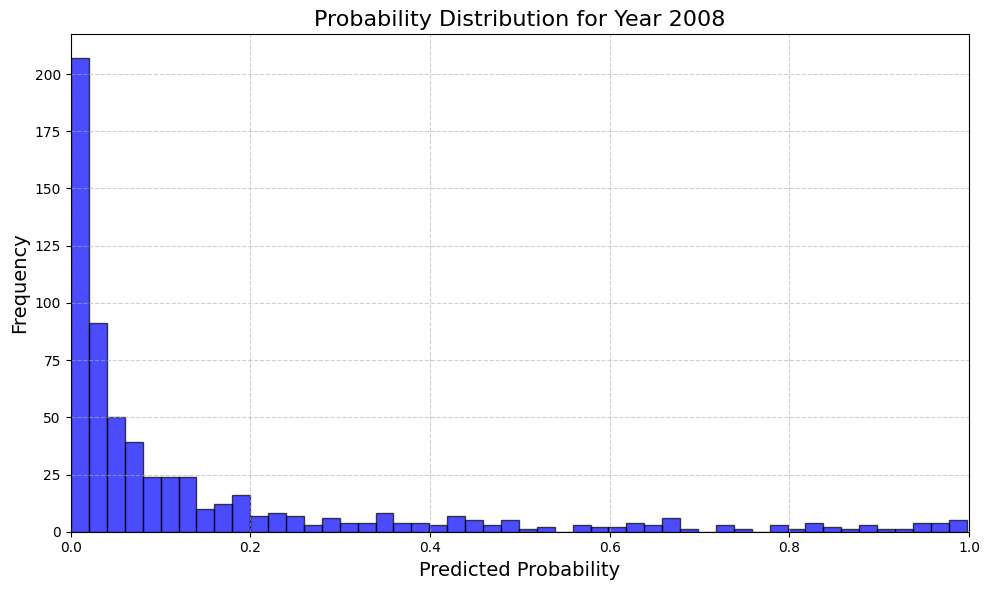

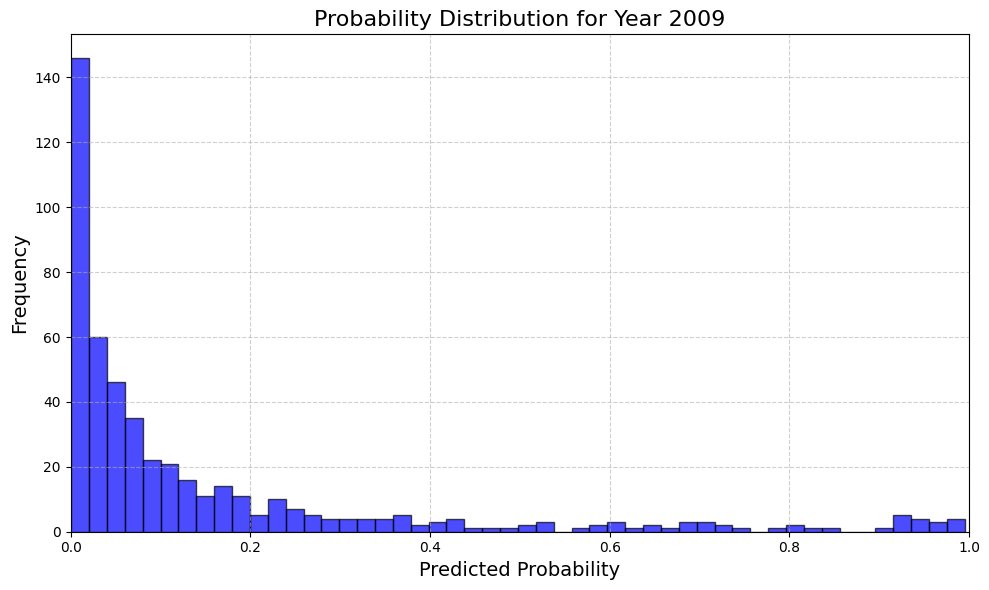

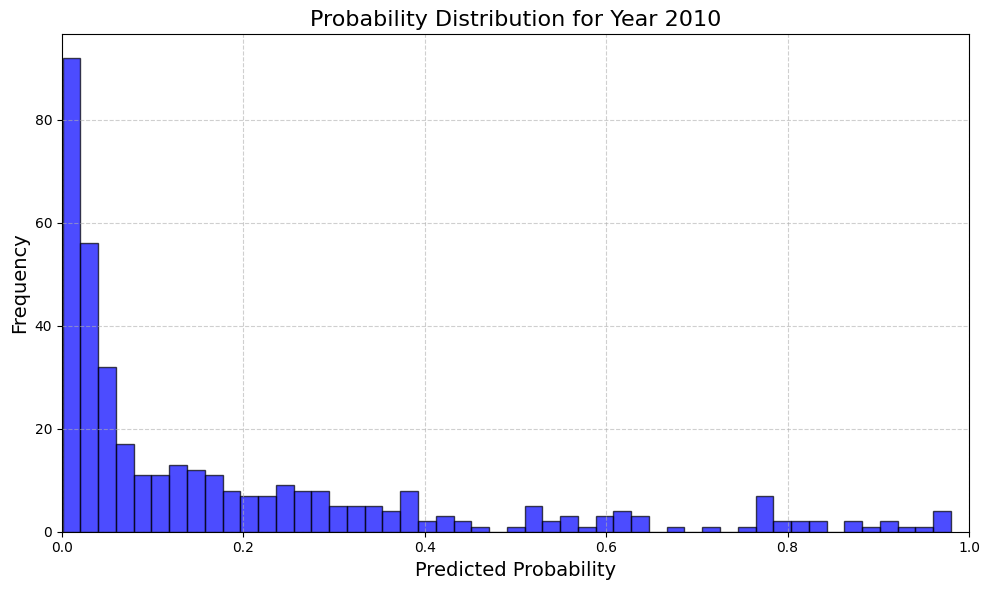

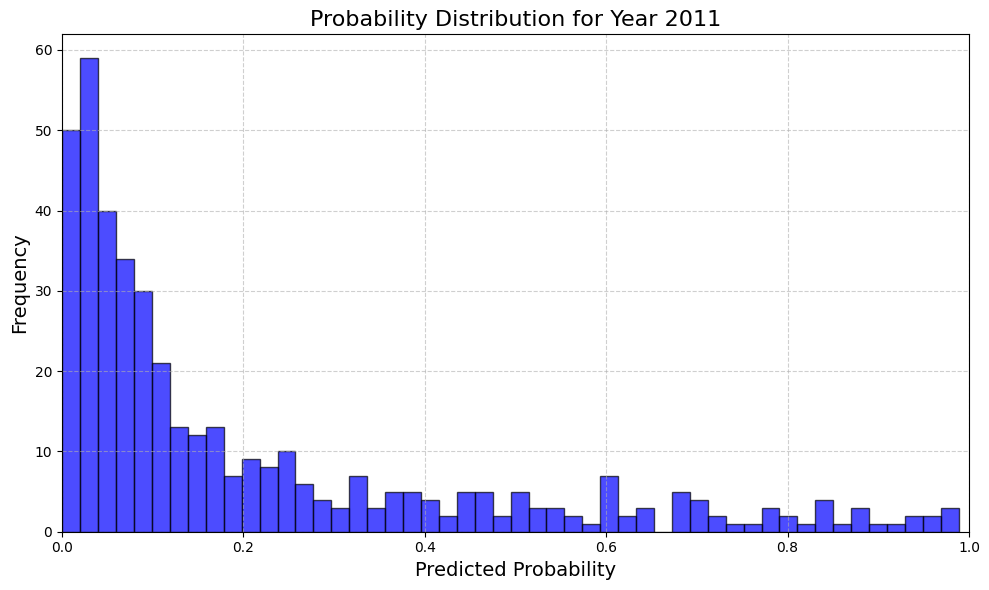

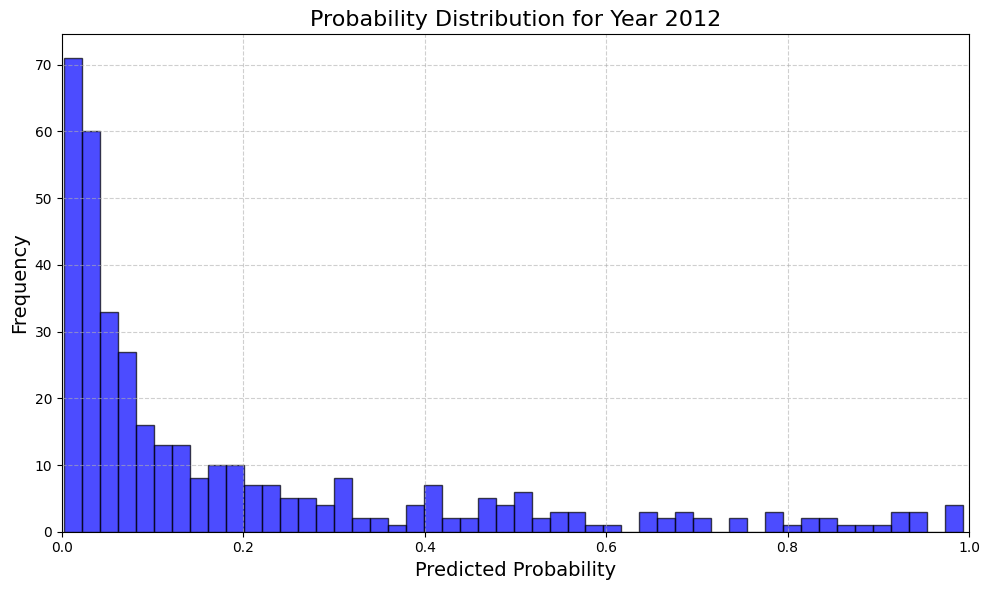

In [27]:
# ווידוא שעומדת "שנת פתיחת ההליך" קיימת
if "שנת פתיחת ההליך" not in cut_sample_df.columns:
    raise ValueError("עמודת 'שנת פתיחת ההליך' חסרה ב-DataFrame.")

# קריאה לפונקציה להצגת גרף נפרד לכל שנה
plot_probability_distribution_separate_by_year(cut_sample_df, "שנת פתיחת ההליך", "predicted_probability")


# Second classifier prediction  

In [28]:
# df = pd.read_excel("2_full_data_with_predictions.xlsx")

In [29]:
df = cut_sample_df.copy()

In [30]:
df[df["prediction_adjusted_threshold"]==1].shape[0]

157

In [31]:
df[df["prediction_adjusted_threshold"]==0].shape[0]

2143

In [32]:
df[df["prediction_adjusted_threshold"]==1]

,level_0,index,גוף המסמך,מספר הליך,שם הליך,שנת פתיחת ההליך,גוף המסמך חתוך,predicted_probability,prediction_original_model,prediction_adjusted_threshold
18,18,2220,"['החלטה בתיק רע""פ 6487/12 בבית המשפט העליון רע...","רע""פ 6487/12","רע""פ 6487/12 צבי דביר נ. מדינת ישראל",2012,כבוד השופט ח\' מלצר כבוד השופט א\' שהם המבקש: ...,0.927617,1,1
19,19,2221,"['החלטה בתיק רע""פ 6585/12 בבית המשפט העליון רע...","רע""פ 6585/12","רע""פ 6585/12 חאנ האביב אירועימ בע""מ נ. מדינת י...",2012,ע ספק. ח. נוכח פסק הדין נשוא הבקשה בידי המבקשי...,0.891004,1,1
22,22,2224,"['פסק דין בתיק רע""פ 2280/12 בבית המשפט העליון ...","רע""פ 2280/12","רע""פ 2280/12 דוד ברזילאי נ. מדינת ישראל",2012,ניתנה רשות ערעור והערעור הוגש והתקבל באופן שהי...,0.822906,1,1
28,28,2230,"['החלטה בתיק רע""פ 6270/12 בבית המשפט העליון רע...","רע""פ 6270/12","רע""פ 6270/12 יורמ הופטמנ נ. עיריית תל אביב -יפו",2012,קובעת הוא כי התמרור שליד בית מס\' 31 תקף גם ב...,0.710138,1,1
41,41,2243,"['החלטה בתיק רע""פ 84/12 בבית המשפט העליון רע""פ...","רע""פ 84/12","רע""פ 84/12 נאגה בע""מ נ. מדינת ישראל",2012,"ההרשעה. סברנו עם זאת, כי שמא ראוי להפחית בהסכ...",0.809881,1,1
...,...,...,...,...,...,...,...,...,...,...
2268,2294,6710,"['החלטה בתיק רע""פ 4186/11 בבית המשפט העליון רע...","רע""פ 4186/11","רע""פ 4186/11 רמי בוכריס נ. מדינת ישראל",2011,4186/11 - ב\' בפני: כבוד השופט ס\' ג\'ובראן ה...,0.871912,1,1
2275,2301,6717,"['החלטה בתיק רע""פ 8159/11 בבית המשפט העליון רע...","רע""פ 8159/11","רע""פ 8159/11 יאסינ מקוואי נ. מדינת ישראל",2011,"['החלטה בתיק רע""פ 8159/11 בבית המשפט העליון רע...",0.830908,1,1
2277,2303,6719,"['החלטה בתיק רע""פ 3072/11 בבית המשפט העליון רע...","רע""פ 3072/11","רע""פ 3072/11 אלעזר קרבסקי נ. מדינת ישראל",2011,השלכות תכנוניות גם לשירותים הניתנים לאותן דיר...,0.676087,1,1
2287,2314,6730,"['החלטה בתיק רע""פ 5918/11 בבית המשפט העליון רע...","רע""פ 5918/11","רע""פ 5918/11 רותי דוד נ. מדינת ישראל",2011,"באופן ברור כהמשך ישיר של המיוחס למבקשת 1, ובפ...",0.721214,1,1


In [33]:
data = df[df["prediction_adjusted_threshold"]==1]

In [34]:
# פונקציה שמקבלת טקסט ומחזירה את האימבדינג כוקטור
def get_embeddings(text):
    # המרת הטקסט לפורמט מתאים למודל
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    # חישוב האימבדינג של המודל
    outputs = model(**inputs)
    # חישוב ממוצע הוקטורים עבור כל טקסט
    embeddings = outputs.last_hidden_state.mean(dim=1).detach().numpy()
    return embeddings[0]

In [35]:
data["גוף המסמך חתוך מסווג שני"] = data["גוף המסמך"].apply(lambda x: trim_text(x, 550, 80))

Trimmed Text (Original Length: 617, Trimmed Length: 537):
['החלטה בתיק רע"פ 6487/12 בבית המשפט העליון רע"פ 6487/12 לפני: כבוד השופט ס\' ג\
'ובראן כבוד השופט ח\' מלצר כבוד השופט א\' שהם המבקש: צבי דביר נגד המשיבה: מדינת 
ישראל הודעה מטעם המבקש המבקש: בעצמו בשם המשיבה: עו"ד הילה גורני החלטה מאחר שהמבק
ש שילם את מרבית סכום הקנס שהושת עליו (1,750 ₪ מתוך סכום של 2,000 ₪), הננו מחליטי
ם, לפנים משורת הדין, למחוק את יתרת הקנס שלא שולמה, על-מנת להביא פרשה זו לידי סיו
ם. ניתנה היום, ד\' באדר א\' התשע"ד (\u200f4.2.2014). ש ו פ ט ש ו פ ט ש ו פ ט ___
______________________ העותק כפוף לשינויי עריכה וניסוח. 1
##*******************************************************####
Trimmed Text (Original Length: 8400, Trimmed Length: 550):
צו, אלא ארכה היא שניתנה. בשולי הדברים אעיר, כי אולי עדיף היה שבית המשפט קמא יפרט
 דברים אלה, כדי למנוע ספק. ח. נוכח פסק הדין נשוא הבקשה בידי המבקשים להמשיך ולהפע
יל את גן האירועים במתכונת הנוכחית עד ליום 30.4.13 ללא אכיפה נגדם. בזמן זה בידיהם
 לפעול כדי להשיג את האישורים הנדרש

<ipython-input-35-4895bebb659d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["גוף המסמך חתוך מסווג שני"] = data["גוף המסמך"].apply(lambda x: trim_text(x, 550, 80))


In [36]:
embeddings_new_2 = np.array([get_embeddings(text) for text in data["גוף המסמך חתוך מסווג שני"]])

In [37]:
second_classifier = joblib.load("second_classifier_model.pkl")
print("המודל נטען בהצלחה.")


predicted_probabilities = second_classifier.predict_proba(embeddings_new_2)[:, 1]
data["prediction_second_model"] = second_classifier.predict(embeddings_new_2)


data["prediction_second_model"] = second_classifier.predict(embeddings_new_2)
data["second_model_predicted_probability"] = predicted_probabilities

# **תוספת סעיף 4**: בדיקת התפלגות התחזיות
class_distribution = data["prediction_second_model"].value_counts()
print("\nכמות Class 0 ו-Class 1 (לפי המודל המקורי):")
print(class_distribution)

# בדיקת התפלגות נורמלית
normalized_distribution = data["prediction_second_model"].value_counts(normalize=True)
print("\nהתפלגות נורמלית של Class 0 ו-Class 1 (לפי המודל המקורי):")
print(normalized_distribution)

המודל נטען בהצלחה.

כמות Class 0 ו-Class 1 (לפי המודל המקורי):
prediction_second_model
1    114
0     43
Name: count, dtype: int64

התפלגות נורמלית של Class 0 ו-Class 1 (לפי המודל המקורי):
prediction_second_model
1    0.726115
0    0.273885
Name: proportion, dtype: float64


<ipython-input-37-a1c80fe7283d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["prediction_second_model"] = second_classifier.predict(embeddings_new_2)
<ipython-input-37-a1c80fe7283d>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["prediction_second_model"] = second_classifier.predict(embeddings_new_2)
<ipython-input-37-a1c80fe7283d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

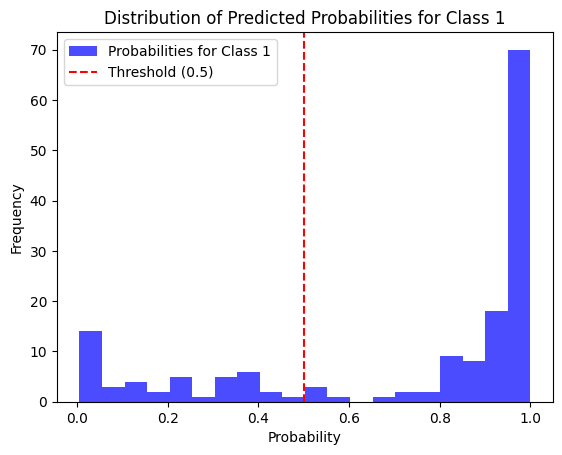

In [38]:
import matplotlib.pyplot as plt

# התפלגות ההסתברויות
plt.hist(predicted_probabilities, bins=20, alpha=0.7, color='blue', label='Probabilities for Class 1')
plt.axvline(0.5, color='red', linestyle='--', label='Threshold (0.5)')
plt.title("Distribution of Predicted Probabilities for Class 1")
plt.xlabel("Probability")
plt.ylabel("Frequency")
plt.legend()
plt.show()


In [39]:
# קביעת סף מותאם
threshold = 0.96

# יצירת תחזיות לפי סף מותאם (0.6)
data["prediction_second_model_adjusted"] = (predicted_probabilities > threshold).astype(int)

# בדיקת התפלגות התחזיות עם הסף החדש
adjusted_class_distribution = data["prediction_second_model_adjusted"].value_counts()
print("\nכמות Class 0 ו-Class 1 (לפי הסף המותאם):")
print(adjusted_class_distribution)

# בדיקת התפלגות נורמלית עם הסף החדש
adjusted_normalized_distribution = data["prediction_second_model_adjusted"].value_counts(normalize=True)
print("\nהתפלגות נורמלית של Class 0 ו-Class 1 (לפי הסף המותאם):")
print(adjusted_normalized_distribution)

# # שמירת הנתונים עם התחזיות המותאמות לקובץ Excel
# output_file_adjusted = "data_with_second_model_adjusted_predictions.xlsx"
# data.to_excel(output_file_adjusted, index=False, engine="openpyxl")
# print(f"הטבלה המלאה עם התחזיות המותאמות נשמרה בקובץ: '{output_file_adjusted}'")



כמות Class 0 ו-Class 1 (לפי הסף המותאם):
prediction_second_model_adjusted
0    91
1    66
Name: count, dtype: int64

התפלגות נורמלית של Class 0 ו-Class 1 (לפי הסף המותאם):
prediction_second_model_adjusted
0    0.579618
1    0.420382
Name: proportion, dtype: float64


<ipython-input-39-c5dc0518e022>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["prediction_second_model_adjusted"] = (predicted_probabilities > threshold).astype(int)


In [40]:
data = pd.concat([data,df])

In [41]:
data.drop_duplicates(subset = ["מספר הליך"],keep = 'first', inplace=True)

In [42]:
# שמירה של התחזיות והנתונים לקובץ Excel
output_file = "full_data_both_models_with_predictions.xlsx"
data.to_excel(output_file, index=False, engine="openpyxl")
print(f"הטבלה המלאה עם הפרדיקציות נשמרה בקובץ: '{output_file}'")


הטבלה המלאה עם הפרדיקציות נשמרה בקובץ: 'full_data_both_models_with_predictions.xlsx'


In [43]:
data[data["prediction_second_model_adjusted"]==0]

,level_0,index,גוף המסמך,מספר הליך,שם הליך,שנת פתיחת ההליך,גוף המסמך חתוך,predicted_probability,prediction_original_model,prediction_adjusted_threshold,גוף המסמך חתוך מסווג שני,prediction_second_model,second_model_predicted_probability,prediction_second_model_adjusted
18,18,2220,"['החלטה בתיק רע""פ 6487/12 בבית המשפט העליון רע...","רע""פ 6487/12","רע""פ 6487/12 צבי דביר נ. מדינת ישראל",2012,כבוד השופט ח\' מלצר כבוד השופט א\' שהם המבקש: ...,0.927617,1,1,"['החלטה בתיק רע""פ 6487/12 בבית המשפט העליון רע...",1.0,0.901553,0.0
19,19,2221,"['החלטה בתיק רע""פ 6585/12 בבית המשפט העליון רע...","רע""פ 6585/12","רע""פ 6585/12 חאנ האביב אירועימ בע""מ נ. מדינת י...",2012,ע ספק. ח. נוכח פסק הדין נשוא הבקשה בידי המבקשי...,0.891004,1,1,"צו, אלא ארכה היא שניתנה. בשולי הדברים אעיר, כי...",0.0,0.447094,0.0
28,28,2230,"['החלטה בתיק רע""פ 6270/12 בבית המשפט העליון רע...","רע""פ 6270/12","רע""פ 6270/12 יורמ הופטמנ נ. עיריית תל אביב -יפו",2012,קובעת הוא כי התמרור שליד בית מס\' 31 תקף גם ב...,0.710138,1,1,איה נוספת ניתן היה להמציא עוד לבית המשפט לעניי...,0.0,0.218207,0.0
102,104,2306,"['החלטה בתיק רע""פ 9012/12 בבית המשפט העליון רע...","רע""פ 9012/12","רע""פ 9012/12 מחאמיד בסאמ ח'אלד נ. מדינת ישראל ...",2012,נ\' ג\'האד (01.03.2012) באשר לסמכותה של ועדה ...,0.861684,1,1,"ן היום בעע""ם 8324/12 ועע""ם 8502/12. בפסק-הדין ...",1.0,0.829187,0.0
125,127,2329,"['החלטה בתיק רע""פ 6431/12 בבית המשפט העליון רע...","רע""פ 6431/12","רע""פ 6431/12 אלעזר הרוש נ. מדינת ישראל",2012,(פסקה 10 לבקשת רשות הערעור). בית המשפט המחוזי ...,0.924437,1,1,ה זו בחזרתו מהערעור. יש לציין כי אף המבקש בעצמ...,0.0,0.206303,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2268,2294,6710,"['החלטה בתיק רע""פ 4186/11 בבית המשפט העליון רע...","רע""פ 4186/11","רע""פ 4186/11 רמי בוכריס נ. מדינת ישראל",2011,4186/11 - ב\' בפני: כבוד השופט ס\' ג\'ובראן ה...,0.871912,1,1,"['החלטה בתיק רע""פ 4186/11 בבית המשפט העליון רע...",0.0,0.471078,0.0
2275,2301,6717,"['החלטה בתיק רע""פ 8159/11 בבית המשפט העליון רע...","רע""פ 8159/11","רע""פ 8159/11 יאסינ מקוואי נ. מדינת ישראל",2011,"['החלטה בתיק רע""פ 8159/11 בבית המשפט העליון רע...",0.830908,1,1,"['החלטה בתיק רע""פ 8159/11 בבית המשפט העליון רע...",0.0,0.175363,0.0
2277,2303,6719,"['החלטה בתיק רע""פ 3072/11 בבית המשפט העליון רע...","רע""פ 3072/11","רע""פ 3072/11 אלעזר קרבסקי נ. מדינת ישראל",2011,השלכות תכנוניות גם לשירותים הניתנים לאותן דיר...,0.676087,1,1,"עניינים מקומיים: ""קיימת משמעות תכנונית לכך שבמ...",0.0,0.029971,0.0
2287,2314,6730,"['החלטה בתיק רע""פ 5918/11 בבית המשפט העליון רע...","רע""פ 5918/11","רע""פ 5918/11 רותי דוד נ. מדינת ישראל",2011,"באופן ברור כהמשך ישיר של המיוחס למבקשת 1, ובפ...",0.721214,1,1,"קשת 1 בעבירה של שימוש ללא היתר, בהתבסס על סעיף...",0.0,0.350754,0.0


In [44]:
data

,level_0,index,גוף המסמך,מספר הליך,שם הליך,שנת פתיחת ההליך,גוף המסמך חתוך,predicted_probability,prediction_original_model,prediction_adjusted_threshold,גוף המסמך חתוך מסווג שני,prediction_second_model,second_model_predicted_probability,prediction_second_model_adjusted
18,18,2220,"['החלטה בתיק רע""פ 6487/12 בבית המשפט העליון רע...","רע""פ 6487/12","רע""פ 6487/12 צבי דביר נ. מדינת ישראל",2012,כבוד השופט ח\' מלצר כבוד השופט א\' שהם המבקש: ...,0.927617,1,1,"['החלטה בתיק רע""פ 6487/12 בבית המשפט העליון רע...",1.0,0.901553,0.0
19,19,2221,"['החלטה בתיק רע""פ 6585/12 בבית המשפט העליון רע...","רע""פ 6585/12","רע""פ 6585/12 חאנ האביב אירועימ בע""מ נ. מדינת י...",2012,ע ספק. ח. נוכח פסק הדין נשוא הבקשה בידי המבקשי...,0.891004,1,1,"צו, אלא ארכה היא שניתנה. בשולי הדברים אעיר, כי...",0.0,0.447094,0.0
22,22,2224,"['פסק דין בתיק רע""פ 2280/12 בבית המשפט העליון ...","רע""פ 2280/12","רע""פ 2280/12 דוד ברזילאי נ. מדינת ישראל",2012,ניתנה רשות ערעור והערעור הוגש והתקבל באופן שהי...,0.822906,1,1,"ק בשם המשיבה: עו""ד אבי וסטרמן פסק דין השופט נ\...",1.0,0.996597,1.0
28,28,2230,"['החלטה בתיק רע""פ 6270/12 בבית המשפט העליון רע...","רע""פ 6270/12","רע""פ 6270/12 יורמ הופטמנ נ. עיריית תל אביב -יפו",2012,קובעת הוא כי התמרור שליד בית מס\' 31 תקף גם ב...,0.710138,1,1,איה נוספת ניתן היה להמציא עוד לבית המשפט לעניי...,0.0,0.218207,0.0
41,41,2243,"['החלטה בתיק רע""פ 84/12 בבית המשפט העליון רע""פ...","רע""פ 84/12","רע""פ 84/12 נאגה בע""מ נ. מדינת ישראל",2012,"ההרשעה. סברנו עם זאת, כי שמא ראוי להפחית בהסכ...",0.809881,1,1,"ג\'ובראן. בתום הדיון, לאחר שמיעה נרחבת של טענו...",1.0,0.982077,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2295,2322,6738,"['החלטה בתיק רע""פ 8581/11 בבית המשפט העליון רע...","רע""פ 8581/11","רע""פ 8581/11 יוספ ניסימ סטיונ נ. מדינת ישראל",2011,"ב: מדינת ישראל בשם המבקש: עו""ד יואב ציוני החלט...",0.288392,0,0,NaN,NaN,NaN,NaN
2296,2323,6739,"['החלטה בתיק רע""פ 1728/11 בבית המשפט העליון רע...","רע""פ 1728/11","רע""פ 1728/11 מאיר לוי נ. מדינת ישראל",2011,ידת מהימנות העדים שהעידו בפני הערכאה הדיונית (...,0.055941,0,0,NaN,NaN,NaN,NaN
2297,2324,6740,"['החלטה בתיק רע""פ 3371/11 בבית המשפט העליון רע...","רע""פ 3371/11","רע""פ 3371/11 אור וקנינ נ. התובע הצבאי הראשי",2011,צדיק מתן רשות ערעור לבית משפט זה בשים לב לכך ש...,0.024084,0,0,NaN,NaN,NaN,NaN
2298,2325,6741,"['החלטה בתיק רע""פ 3352/11 בבית המשפט העליון רע...","רע""פ 3352/11","רע""פ 3352/11 אריה כדורי נ. מדינת ישראל",2011,"1174/97 רפאלי נ\' מדינת ישראל (לא פורסם, 24.3...",0.017643,0,0,NaN,NaN,NaN,NaN
